# Notebook for PSTAT 235 Project


In [136]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.ml.linalg import DenseVector
import pyspark.sql.functions as F
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.types as typ
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.clustering import BisectingKMeans
from pyspark.sql.functions import collect_set
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import Bucketizer


import re
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Jonas_rentalPrice-Copy1") \
    .config("spark.executor.memory", '4g') \
    .config('spark.executor.cores', '1') \
    .config('spark.cores.max', '1') \
    .config("spark.driver.memory",'1g') \
    .getOrCreate()

sc = spark.sparkContext
sqlCtx = SQLContext(sc)

In [137]:
# import as pandas df
data_pd = pd.read_json("data/train.json")

In [138]:
# look at variables
data_pd.head(2)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue,low


# Data Cleaning

In [139]:
## Summary statistics for numerical columns
data_pd.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


The average house has 1 bedroom and 1.5 bathrooms and is priced at about \$3800. Additionally, looking at the min and max values for these columns, we can see that there are some rentals that have 0 bedrooms or 0 bathrooms! The minimum rental price is 43 dollars, and the maximum is 4.5 million. Additionally, we can see some outliers in the latitude and longitude values. There is at least one place listed as being on the equator, and another that has latitude close to that of Vermont. Furthermore, there is at least one place with longitude = 0 (the prime meridian that runs through the UK and West Africa), and one with a longitude of -118.27, which is approximately the longitude of Los Angeles! There's definitely some cleaning to do here!

In [140]:
# Does every listing have a date?
import time
import datetime
set([0<time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple()) for s in data_pd["created"]])

{True}

And all houses in NYC have a posted date

In [141]:
# descriptions
set([len(t.strip())>0 for t in data_pd["description"].tolist()])

{False, True}

In [142]:
# addresses
set([len(t.strip())>0 for t in data_pd["display_address"].tolist()])

{False, True}

In [143]:
# features
set([len(t)>0 for t in data_pd["features"].tolist()])

{False, True}

Some rentals have empty descriptions, addresses, or features

In [144]:
set([t>0 for t in data_pd["latitude"].tolist()])

{False, True}

We know NYC is about 40N, 74W, so rentals with latitude equal to 0 are likely to be errors. We will impute these values.

In [145]:
set([t<0 for t in data_pd["longitude"].tolist()])

{False, True}

In [146]:
set([t>0 for t in data_pd["price"].tolist()])

{True}

All houses are not free, which is good

In [147]:
set([len(t)>0 for t in data_pd["street_address"].tolist()])

{False, True}

There are some observations that do not have **street_address**

In [148]:
set([np.isreal(t) for t in data_pd["listing_id"].tolist()])

{True}

In [149]:
len(list(set(data_pd["listing_id"].tolist())))==len(data_pd["listing_id"].tolist())

True

Each **listing_id** is unique, which is expected

In [150]:
set([t for t in data_pd["interest_level"].tolist()])

{'high', 'low', 'medium'}

Each observation must have an **interest_level** in (high, low, medium)

# Exploratory Data Analysis

Since there is a lot of plotting going on here we will be needing to cenvert a pySpark data frame to a pandas df backa and forth a lot if we are going to be woring with pySpark. To not having to deal with that the whole EDA will be done using pandas data frame.

In [151]:
interest_level_count = dict()
for j in [t for t in data_pd["interest_level"].tolist()]:
    interest_level_count[j] = interest_level_count.get(j,0) + 1
interest_level_count

{'medium': 11229, 'low': 34284, 'high': 3839}

We have counted the number of medium, low, and high. And as you can see, The data is a little bit imbalanced but not severe. 

## bathrooms and bedrooms

We start by plotting some hisograms to see if anything stands out.

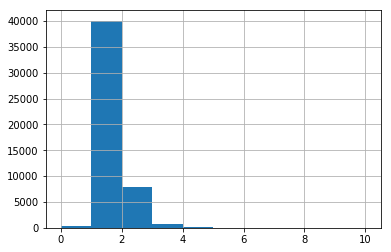

In [152]:
data_pd["bathrooms"].hist()

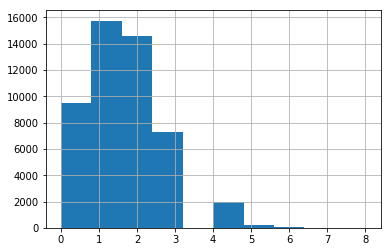

In [153]:
data_pd["bedrooms"].hist()

Continue with plotting.

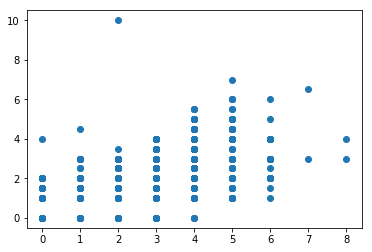

In [154]:
from matplotlib import pyplot as plt
plt.plot(data_pd["bedrooms"], data_pd["bathrooms"], 'o')

From this plot, we can see there is a strange house that has 10 bathrooms but only 2 bedrooms. That is strange, and we may have a check on it

In [155]:
data_pd[data_pd["bathrooms"]==10]["description"].tolist()[0]

'***The building?s well-attended lobby welcomes the residents with its 24-hour doorman and concierge service as well as a fitness center, private storage rooms, bicycle storage, sauna and a laundry area on every floor. Many units have been completely renovated with beautiful new finishes, stone countertops and GE stainless steel appliances. Enjoy the Broadway theater district, Times Square, Central Park and exceptional dining and shopping<br /><br />***HUGE AS BIG AS A FOOT BALL FIELD AND FEATURES HIGH CEILING ,BRAND NEW KITCHEN ,MARBLE BATHROOM, TONS OF CLOSET SPACE ,UNOBSTRUCTED CITY VIEWS AND A TON OF LIGHT DUE TO ITS EXPOSURE AND HIGH FLOOR<br /><br />***TO SET UP TIME AND LOCATION CONTACT RUBENS 039-610-8860<br /><br /><p><a  website_redacted '

We check the images assosiated with the rental unit.

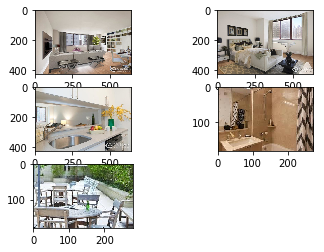

In [156]:
from PIL import Image
import requests
from io import BytesIO

fig = plt.figure()
img_urls = data_pd[data_pd["bathrooms"]==10]["photos"].tolist()

for i in range(0, len(img_urls[0])):
    response = requests.get(img_urls[0][i])
    img = Image.open(BytesIO(response.content))
    ax = fig.add_subplot(3, 2, i+1)
    ax.imshow(img)
    
plt.show()

After checking thses images, we conclude that 10 bathrooms is an entry mistake. Continue to check the correlation between the two.

In [157]:
from sklearn.linear_model import LinearRegression
import scipy
scipy.stats.pearsonr(data_pd["bathrooms"], data_pd["bedrooms"])

(0.5334463134173691, 0.0)

The **bathrooms** and **bedrooms** are not highly correlated

So as wee can see most houses in NYC have less than or equal to two bathrooms and have less than 3 bedrooms.

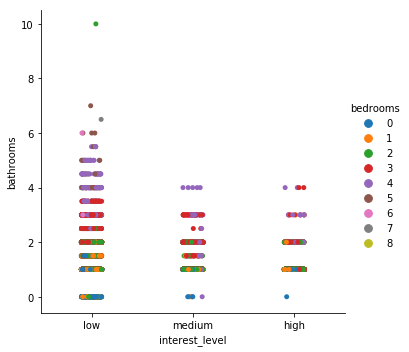

In [161]:
import seaborn
seaborn.catplot(x="interest_level", y="bathrooms", hue = "bedrooms",data = data_pd, order=["low","medium","high"])

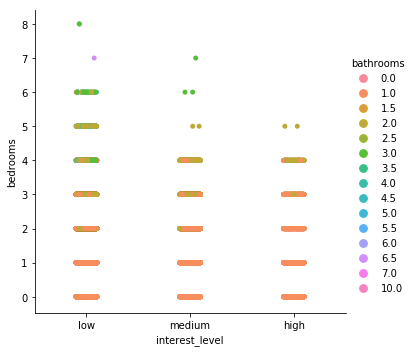

In [25]:
seaborn.catplot(x="interest_level", y="bedrooms", hue = "bathrooms",data = data_pd, order=["low","medium","high"])

We have observed that if there are more than 5 bathrooms or more than 4 bathrooms in a house, the **interest_level** associated with that house can rarely be high

## price

We now investigate the price of for the rental units.

In [26]:
mypal = {"low": "#6da39c", "medium": "#ff9a16", "high":"#77043e"}

We plot the `interest_level` vs the `price`.

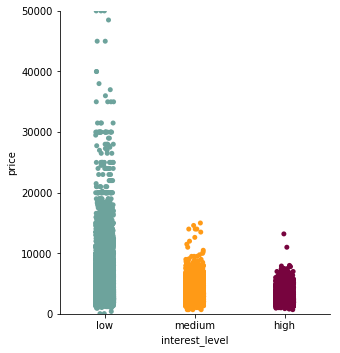

In [27]:
g = seaborn.catplot(x="interest_level", y="price",data = data_pd, order=["low","medium","high"], palette=mypal).set(ylim=(0, 50000))

And we can see the housing rental prices in NYC is very expensive. However, if a house's rental price is more than 10000, the interest level can rarely be high. 

## latitude and longitude

We now check the longitude and latitude of the units.

[(38, 44), (-80, -70)]

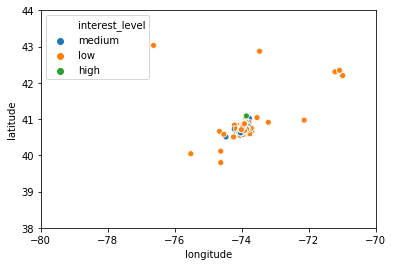

In [28]:
seaborn.scatterplot(x="longitude",
                    y="latitude",
                    hue = "interest_level",
                    data = data_pd).set(ylim=(38, 44),xlim=(-80,-70))

Let's zoom in for a little bit

[(40.4, 41), (-74.25, -73.75)]

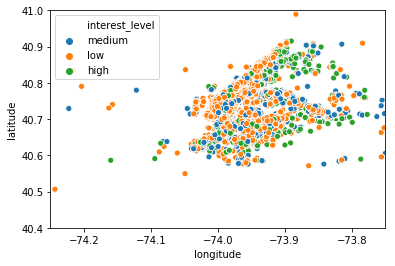

In [29]:
seaborn.scatterplot(x="longitude",
                    y="latitude",
                    hue = "interest_level",
                    data = data_pd).set(ylim=(40.4, 41),xlim=(-74.25,-73.75))

As we can see, the medium, low, and high are have their own clusters each shape as a narrow oval. Therefore, gaussian mixture model may help in this case. 

To plot the apartments we use the package `folium` which can make interactive plots and we can get more information of the rental units in the plot.

Inspiration from blogpost: https://nbviewer.jupyter.org/github/vincentropy/python_cartography_tutorial/blob/master/part1_basic_folium_maps.ipynb

Uncomment to install `folium`.

In [162]:
# !pip install --upgrade folium
# import folium

  Using cached https://files.pythonhosted.org/packages/47/28/b3199bf87100e389c1dff88a44a38936d27e5e99eece870b5308186217c8/folium-0.8.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/63/36/1c93318e9653f4e414a2e0c3b98fc898b4970e939afeedeee6075dd3b703/branca-0.3.1-py3-none-any.whl
You are using pip version 19.0.2, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


We create a function that places each of the units on the map. The color of the apartment corresponds to the factor `interest_level` which has not been investigated thoroughly yet. The size of the circle is based on the price which can be displayed by *klicking* the circle, along with the `street_address`.

In [168]:
def plot_rental_locatinos(rental_locatinos):
        # generate a new map
    folium_map = folium.Map(location=[40.738, -73.98],
                            zoom_start=13,
                            tiles="CartoDB dark_matter",
                            width='50%')

            
    for index, row in rental_locatinos.iterrows():
        
            popup_text = "{}<br> Price: {}<br>"
            popup_text = popup_text.format(row["street_address"], row["price"])
            
            if row["interest_level"] == 'high':
                color="#77043e" # high
            if row["interest_level"] == 'medium':
                color="#ff9a16" # medium 
            if row["interest_level"] == 'low':
                color="#6da39c" # low
                
            radius = row["price"]/1000
        
            folium.CircleMarker(location=(row["latitude"],
                                      row["longitude"]),
                            radius=radius,
                            color=color,
                            popup=popup_text,
                            fill=True).add_to(folium_map)
    return folium_map

Since our data set is too big for all rental units to be displayed a subsample of 1000 units are changed into a pandas data frame which is then plotted using the above constructed function `plot_rental_locatinos`.

In [165]:
sample_pd = data_pd.sample(n = 1000)

The user constructed function `plot_rental_locatinos` is used on the `sample_df`. Try draging, scrolling and moving around and klick different rental units for some basic information.

In [169]:
plot_rental_locatinos(sample_pd)

## created

We now investigate when listing was created.

In [30]:
createdUnixTime = list(map(lambda s:time.mktime(datetime.datetime.strptime(s, 
                                                         "%Y-%m-%d %H:%M:%S").timetuple()), 
         data_pd["created"].tolist()))

(0.0, 3550.0)

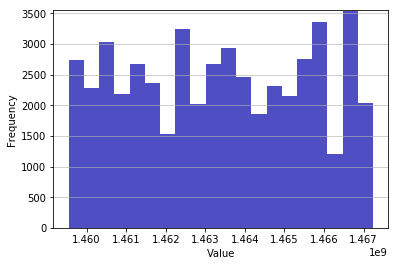

In [31]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=createdUnixTime, 
                            bins=20, 
                            color='#0504aa',
                            alpha=0.7, rwidth=2)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [32]:
data_pd["createdUnixTime"] = createdUnixTime

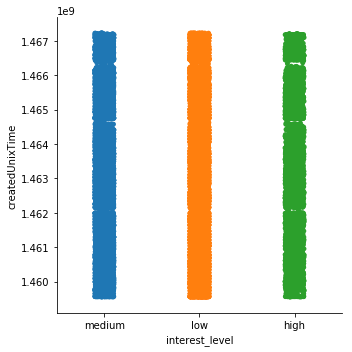

In [33]:
seaborn.catplot(x="interest_level", y="createdUnixTime",data = data_pd)

As you can see the created time for **high** has some gaps that **medium** and **low** does not have, so we may be able to utilize that after some careful feature engineering. 

## features

The column called `features` (yes we know that name is stupid... it has caused some confusion to say the least) consists of different features assosiated with the rental unit. For example: _doorman, cats allowed, loft_.

We plot the number of features for the different units.

(0.0, 11150.0)

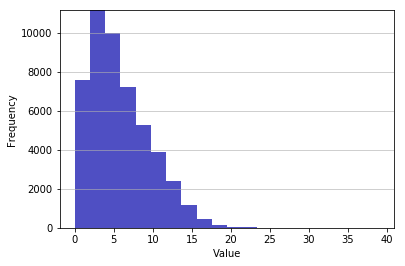

In [34]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=[len(t) for t in data_pd["features"].tolist()], 
                            bins=20, 
                            color='#0504aa',
                            alpha=0.7, rwidth=2)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of features')
plt.ylabel('Frequency')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

And most rows in the **features** column have less than 10 items

In [35]:
data_pd["features_len"] = list(map(len, data_pd["features"].tolist()))

Here are the numbers of features assosiated with the different interest levels.

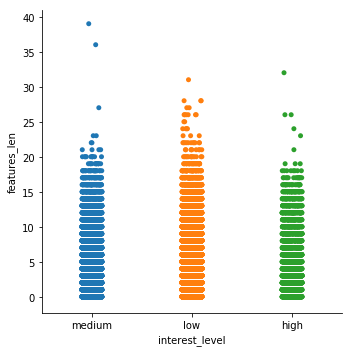

In [36]:
seaborn.catplot(x="interest_level",
                    y="features_len",
                    data = data_pd)

And seems like the length of the **features** does not help...

# Feature Engineering

The different columns in the data set that will be used for feature engineering are:
- `features`
- `manager_id`
- `latitude and longitude`
- `description`
- `images`

Here follows the course of action for each of these columns in code.

Since the exploratory data analysis was done using a panadas data frame we will now convert it into a pySpark data fram called `df`.

In [37]:
df = sqlCtx.createDataFrame(data_pd)

Printing the schema. Seems to be ok for most part. The `created` should be changed from string to time object.

In [38]:
df.printSchema()

root
 |-- bathrooms: double (nullable = true)
 |-- bedrooms: long (nullable = true)
 |-- building_id: string (nullable = true)
 |-- created: string (nullable = true)
 |-- description: string (nullable = true)
 |-- display_address: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- latitude: double (nullable = true)
 |-- listing_id: long (nullable = true)
 |-- longitude: double (nullable = true)
 |-- manager_id: string (nullable = true)
 |-- photos: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- price: long (nullable = true)
 |-- street_address: string (nullable = true)
 |-- interest_level: string (nullable = true)
 |-- createdUnixTime: double (nullable = true)
 |-- features_len: long (nullable = true)



In [39]:
df = df.withColumn("created", F.to_timestamp("created"))
df.cache()

DataFrame[bathrooms: double, bedrooms: bigint, building_id: string, created: timestamp, description: string, display_address: string, features: array<string>, latitude: double, listing_id: bigint, longitude: double, manager_id: string, photos: array<string>, price: bigint, street_address: string, interest_level: string, createdUnixTime: double, features_len: bigint]

## The column `features`

The goal here is to divide the different individual features into different clusters. And make 1 new column per cluster in the data set and then fit a regression model on the clusters. How ever the implementation when running the model was a little different

We have to handle the rentals with missing featurses by adding `missing feature` as a feature. Here are the 2 first listings with missing features.

In [40]:
df.filter(F.size("features")==0)[["listing_id", "features"]].show(2)

+----------+--------+
|listing_id|features|
+----------+--------+
|   7211212|      []|
|   6894514|      []|
+----------+--------+
only showing top 2 rows



But first since the column `features` is a list containing strings, we want to mearge the list of strings to one string. We do this by constructing a `UserDefinedFunction` named `string_assembler` which uses the `','.join()` to join strings in a list and separating them with a **,** . This is what we do: \['dog', 'cat'\] -> 'dog,cat'.

In [41]:
string_assembler = F.UserDefinedFunction(lambda x: ','.join(x), typ.StringType())

The function `string_assembler` is used on the column `features`.

In [42]:
df = df.withColumn("features", string_assembler(df["features"]))

All strings are set to lower case.

In [43]:
df = df.withColumn("features", F.lower(df["features"]))

A display of what we have done. Note that the first row is missing any `features`. This is valuable information as well since a listing ad without information about the rental place could determin the popularity of the place.


In [44]:
df[["features"]].show(5)

+--------------------+
|            features|
+--------------------+
|                    |
|doorman,elevator,...|
|laundry in buildi...|
|hardwood floors,n...|
|             pre-war|
+--------------------+
only showing top 5 rows



We impute all missing `features` with the string "missing feature" and show the results.

In [45]:
df = df.withColumn("features", 
                    F.when(df["features"] == '', 'missing features')
                    .otherwise(df["features"]))
df[["features"]].show(5)

+--------------------+
|            features|
+--------------------+
|    missing features|
|doorman,elevator,...|
|laundry in buildi...|
|hardwood floors,n...|
|             pre-war|
+--------------------+
only showing top 5 rows



We want to split the `features` string on **","** and on __"*"__ since some listings had all features in one long string with * separating the different features. 

In [46]:
feat_df = df.withColumn("features_list", F.split(df["features"], ',| \* '))
feat_df[["features_list"]].show(5)

+--------------------+
|       features_list|
+--------------------+
|  [missing features]|
|[doorman, elevato...|
|[laundry in build...|
|[hardwood floors,...|
|           [pre-war]|
+--------------------+
only showing top 5 rows



Now we want to create one feature be uniqe feature in the `features`. The first step is to 'explode' the features so that each single feature gets it's own row.

![Explode%20column.jpg](attachment:Explode%20column.jpg)

In [47]:
feat_df_ex = feat_df.withColumn("ex_features_list", F.explode(feat_df["features_list"]))

We create a data frame called `clustering_df` which contains all different featurese.

In [48]:
clustering_df = feat_df_ex[["ex_features_list"]]
clustering_df.cache()
clustering_df.show(5)

+----------------+
|ex_features_list|
+----------------+
|missing features|
|         doorman|
|        elevator|
|  fitness center|
|    cats allowed|
+----------------+
only showing top 5 rows



Change the name of the column from "ex_features_list" to "text".

In [49]:
clustering_df = clustering_df.withColumnRenamed("ex_features_list", "text")
clustering_df.columns

['text']

Here we create a new data frame `pipelined_df`. In the pipeline we use `Tokenizer`, to divide features with several words into as few meaningful components as possible, `StopWordsRemover` to remove unnecessary words, `HashingTF` to convert the strings into number, and finally, `IDF` (inverse document frequency) which is a measurement of the importance of a word in a document.

In [50]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer, StopWordsRemover
from pyspark.ml.pipeline import Pipeline

tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
remover = StopWordsRemover(inputCol="tokens", outputCol="stopWordsRemovedTokens")
hashingTF = HashingTF(inputCol="stopWordsRemovedTokens", outputCol="rawFeatures", numFeatures=2000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5)

pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf])
pipelined_df = pipeline.fit(clustering_df).transform(clustering_df)

The pipelined data frame can be seen here:

In [51]:
pipelined_df.show(5)

+----------------+-------------------+----------------------+--------------------+--------------------+
|            text|             tokens|stopWordsRemovedTokens|         rawFeatures|            features|
+----------------+-------------------+----------------------+--------------------+--------------------+
|missing features|[missing, features]|   [missing, features]|(2000,[1525,1755]...|(2000,[1525,1755]...|
|         doorman|          [doorman]|             [doorman]|  (2000,[825],[1.0])|(2000,[825],[2.55...|
|        elevator|         [elevator]|            [elevator]|   (2000,[31],[1.0])|(2000,[31],[2.335...|
|  fitness center|  [fitness, center]|     [fitness, center]|(2000,[1173,1966]...|(2000,[1173,1966]...|
|    cats allowed|    [cats, allowed]|       [cats, allowed]|(2000,[1350,1966]...|(2000,[1350,1966]...|
+----------------+-------------------+----------------------+--------------------+--------------------+
only showing top 5 rows



We are not reay to cluseter the data frame `pipelined_df` which by default uses K-means on the column `features`. `BisectingKMeans` is used for clustering. It was choosen since the normal K-means clustered allmost all observations in the same cluster while `BisectingKMeans` had the observations more eavenly spread out over different clusters.

To find the best number of clusters `k` the elbow method is used. __These lines of code takes time to run and could be skiped__, k = 18 using the Elbow method.

In [52]:
# Sum_of_squared_distances = []
# K = [2,10,12,14,16,17,18,19,20,22,30,40]

# for i in K:
#     km = BisectingKMeans(k = i)
#     model = km.fit(pipelined_df)
#     Sum_of_squared_distances.append(model.computeCost(pipelined_df))
#     print(i)
 
# plt.plot(K, Sum_of_squared_distances, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Sum_of_squared_distances')
# plt.title('Elbow Method For Optimal k')
# plt.show()

From the plot and the elbow method for optimal `k` indikates k = 18.

In [56]:
num_k = 18

We train the model using the `k` choosen by the elbow method.

In [57]:
km = BisectingKMeans(k = num_k)
model = km.fit(pipelined_df)

The results are printed.

In [58]:
results = model.transform(pipelined_df)
results.cache()
results.show(5)

+----------------+-------------------+----------------------+--------------------+--------------------+----------+
|            text|             tokens|stopWordsRemovedTokens|         rawFeatures|            features|prediction|
+----------------+-------------------+----------------------+--------------------+--------------------+----------+
|missing features|[missing, features]|   [missing, features]|(2000,[1525,1755]...|(2000,[1525,1755]...|        17|
|         doorman|          [doorman]|             [doorman]|  (2000,[825],[1.0])|(2000,[825],[2.55...|         0|
|        elevator|         [elevator]|            [elevator]|   (2000,[31],[1.0])|(2000,[31],[2.335...|         1|
|  fitness center|  [fitness, center]|     [fitness, center]|(2000,[1173,1966]...|(2000,[1173,1966]...|        10|
|    cats allowed|    [cats, allowed]|       [cats, allowed]|(2000,[1350,1966]...|(2000,[1350,1966]...|         8|
+----------------+-------------------+----------------------+-------------------

The column default output column `precidtion` is changed to `clusters`.

In [59]:
results = results.withColumnRenamed("prediction", "clusters")

In [60]:
join_df = results.drop(*["tokens", "stopWordsRemovedTokens", "rawFeatures", "features"])
join_df.show(10)

+--------------------+--------+
|                text|clusters|
+--------------------+--------+
|    missing features|      17|
|             doorman|       0|
|            elevator|       1|
|      fitness center|      10|
|        cats allowed|       8|
|        dogs allowed|       5|
| laundry in building|       6|
|          dishwasher|       2|
|     hardwood floors|      15|
|pets allowed case...|       8|
+--------------------+--------+
only showing top 10 rows



Some examples of cluseters are displayed bellow where we can see what features get clustered together.

In [61]:
print("Doorman cluster:")
join_df.filter(join_df["clusters"] == 0).distinct().show(5)
print("Loft cluster:")
join_df.filter(join_df["clusters"] == 1).distinct().show(5)
print("Washer cluster:")
join_df.filter(join_df["clusters"] == 10).distinct().show(5)

Doorman cluster:
+--------------------+--------+
|                text|clusters|
+--------------------+--------+
|             doorman|       0|
|          ft doorman|       0|
|twenty-four hour ...|       0|
|no fee...luxury d...|       0|
|        24hr doorman|       0|
+--------------------+--------+
only showing top 5 rows

Loft cluster:
+--------------------+--------+
|                text|clusters|
+--------------------+--------+
|rent stabilize - ...|       1|
|   elevator building|       1|
|  elevator & laundry|       1|
|keyed elevator wi...|       1|
|            elevator|       1|
+--------------------+--------+

Washer cluster:
+--------------------+--------+
|                text|clusters|
+--------------------+--------+
|state of the art ...|      10|
| 24/7 fitness center|      10|
|      fitness center|      10|
|         game center|      10|
|fitness center an...|      10|
+--------------------+--------+
only showing top 5 rows



Now we want to join the two data sets together and create a column to add on.

In [62]:
join_df = join_df.withColumn("join_col", F.monotonically_increasing_id())
feat_df_ex = feat_df_ex.withColumn("join_col", F.monotonically_increasing_id())

The 2 data frames are shown bellow.

In [63]:
join_df.show(3)
feat_df_ex[["ex_features_list", "join_col"]].show(3)

+----------------+--------+--------+
|            text|clusters|join_col|
+----------------+--------+--------+
|missing features|      17|       0|
|         doorman|       0|       1|
|        elevator|       1|       2|
+----------------+--------+--------+
only showing top 3 rows

+----------------+--------+
|ex_features_list|join_col|
+----------------+--------+
|missing features|       0|
|         doorman|       1|
|        elevator|       2|
+----------------+--------+
only showing top 3 rows



We join the 2 data frames based on the created column, which after the join is droped. The columns are displayed below.

In [64]:
joined_df = feat_df_ex.join(join_df, feat_df_ex["join_col"] == join_df["join_col"], how = "left")
joined_df = joined_df.drop("join_col")

The columns `text` and `prediction` are shown.

In [65]:
joined_df[["listing_id", "text", "clusters"]].show(5)

+----------+---------------+--------+
|listing_id|           text|clusters|
+----------+---------------+--------+
|   6867392|laundry in unit|       7|
|   6867392|  outdoor space|       8|
|   6848778|laundry in unit|       7|
|   6862351|   cats allowed|       8|
|   6898347|on-site laundry|       7|
+----------+---------------+--------+
only showing top 5 rows



We then use the function `collect_set` to assemble the clusters assosiated with each `listing_id`.

In [68]:
collect_df = joined_df.groupBy('listing_id').agg(collect_set('clusters').alias('clusters_list'))
collect_df.show(5)

+----------+--------------------+
|listing_id|       clusters_list|
+----------+--------------------+
|   6813946|[15, 9, 1, 5, 6, ...|
|   6816559|[0, 15, 12, 9, 1,...|
|   6817923|           [5, 7, 8]|
|   6819131|[0, 15, 9, 1, 16,...|
|   6820763|[0, 15, 9, 1, 2, ...|
+----------+--------------------+
only showing top 5 rows



Finaly we add the new column to the data set.

In [70]:
new_df = df.join(collect_df, on = "listing_id", how = "left")
new_df.columns

['listing_id',
 'bathrooms',
 'bedrooms',
 'building_id',
 'created',
 'description',
 'display_address',
 'features',
 'latitude',
 'longitude',
 'manager_id',
 'photos',
 'price',
 'street_address',
 'interest_level',
 'createdUnixTime',
 'features_len',
 'clusters_list']

We comclude that the column `clusters_list` has been added to the data frame.

## The column `manager_id`


The managers are not equally skilled in making an add for the rental unit that would cause a high interest level. Therefore we can create a new feature that captures the skill of the manager. 


We create a new column `count` where the number of rentals for each manager is.

In [105]:
join_df = manager_df[["manager_id"]].groupBy("manager_id").count()
manager_df = manager_df.join(join_df, on = "manager_id")

In [106]:
df[["manager_id"]].groupBy("manager_id").count().sort("count", ascending = False).show(4)

+--------------------+-----+
|          manager_id|count|
+--------------------+-----+
|e6472c7237327dd39...| 2533|
|6e5c10246156ae5bd...|  711|
|8f5a9c893f6d602f4...|  410|
|62b685cc0d876c3a1...|  402|
+--------------------+-----+
only showing top 4 rows



The `interest_level` are changed into low = 0, medium = 1, high = 2. 

In [107]:
manager_df = manager_df.withColumn("interest_level", F.when(manager_df["interest_level"] == 'low', 0)
                                         .when(manager_df["interest_level"] == 'medium', 1)
                                         .otherwise(2))
manager_df.cache()
manager_df[["manager_id", "count", "interest_level"]].show(4)

+--------------------+-----+--------------+
|          manager_id|count|interest_level|
+--------------------+-----+--------------+
|13ddb55a3a9d896b4...|   78|             0|
|13ddb55a3a9d896b4...|   78|             0|
|13ddb55a3a9d896b4...|   78|             1|
|13ddb55a3a9d896b4...|   78|             0|
+--------------------+-----+--------------+
only showing top 4 rows



We create a data frame `manager_skill` where for each maneger their skill `manager_skill` was calculated by summing up all of their rentals and give 2 points for interest level "high", 1 point for interest level "medium" and 0 points for interest level "low" and then taking the mean.

In [110]:
manager_skill = manager_df.groupBy("manager_id").agg({"interest_level": "mean"})
manager_skill.show(5)

+--------------------+-------------------+
|          manager_id|avg(interest_level)|
+--------------------+-------------------+
|13ddb55a3a9d896b4...| 0.6282051282051282|
|149323344e4cbdfc6...|                0.0|
|2d1d30f24cd934965...|                0.0|
|370bb26d489837132...|0.38461538461538464|
|4415b8863dc147fc9...|                0.0|
+--------------------+-------------------+
only showing top 5 rows



The name of the column is changed from `avg(interest_level)` to `manager_skill`.

In [111]:
manager_skill = manager_skill.withColumnRenamed("avg(interest_level)", "manager_skill")

We join the dataframes so there is a column `manager_skill` for the original data.

In [112]:
manager_df = manager_df.join(manager_skill, on = "manager_id", how = "left")
manager_df[["interest_level", "manager_id", "manager_skill"]].show(3)

+--------------+--------------------+------------------+
|interest_level|          manager_id|     manager_skill|
+--------------+--------------------+------------------+
|             0|13ddb55a3a9d896b4...|0.6282051282051282|
|             0|13ddb55a3a9d896b4...|0.6282051282051282|
|             1|13ddb55a3a9d896b4...|0.6282051282051282|
+--------------+--------------------+------------------+
only showing top 3 rows



Lastly we bucket the manager skills into different buckets.   
__Note:__ Here the buckets get cast into 3 bucets choosen by a person. The ranges of the buckets should be choosen by K-means or Gaussian Mixture Models. The bucketing was a last minute change which improved the results over not using bucketing anyways. That is the reason the choosing of buckets was not implemented using K-means or Gaussian Mixture Models.

In [113]:
splits = [0,0.66,1.33,float("Inf")]
buck = Bucketizer(splits = splits, inputCol = "manager_skill", outputCol = "manager_bucket")
manager_skill_bucket = buck.transform(manager_skill)
manager_skill_bucket.show(5)

+--------------------+-------------------+--------------+
|          manager_id|      manager_skill|manager_bucket|
+--------------------+-------------------+--------------+
|13ddb55a3a9d896b4...| 0.6282051282051282|           0.0|
|149323344e4cbdfc6...|                0.0|           0.0|
|2d1d30f24cd934965...|                0.0|           0.0|
|370bb26d489837132...|0.38461538461538464|           0.0|
|4415b8863dc147fc9...|                0.0|           0.0|
+--------------------+-------------------+--------------+
only showing top 5 rows



Lastly we add the new column `manager_bucket` and `manager_skill` to the original data frame.

In [115]:
new_df = df.join(manager_skill_bucket, on = "manager_id")
new_df.columns

['manager_id',
 'bathrooms',
 'bedrooms',
 'building_id',
 'created',
 'description',
 'display_address',
 'features',
 'latitude',
 'listing_id',
 'longitude',
 'photos',
 'price',
 'street_address',
 'interest_level',
 'createdUnixTime',
 'features_len',
 'manager_skill',
 'manager_bucket']

We see that the 2 columns have been added to the data frame.

## created

For both model tesing the prediction, the **created** is converted to the unix time, so that becomes a real number suitable for various of models. 

In [35]:
! cat projectModelRunner.py | grep "mktime"

    input_data_pd["created"] = input_data_pd["created"].apply(lambda s: time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple()))
    input_data_pd_train["created"] = input_data_pd_train["created"].apply(lambda s: time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple()))
    input_data_pd_test["created"] = input_data_pd_test["created"].apply(lambda s: time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple()))


## latitude and longitude

In [36]:
! head -49 Miscellaneous/ModelPipConfig.py | tail -15


        assemblerForGMM = VectorAssembler(inputCols=["out_latitude", "out_longitude"],
                                          outputCol="gmmFeatures")


        gmm = GaussianMixture(featuresCol="gmmFeatures",
                              predictionCol="gmmPrediction",
                              k=7,
                              probabilityCol="gmmAssignmentProbability",
                              tol=0.01,
                              maxIter=100,
                              seed=None)

        gmmLabelOneHotEncoder = OneHotEncoder(inputCol="gmmPrediction", outputCol="gmmPredictionVector")



Because we assume that houses' 2D locations with different interest level are distributed in NYC by different Gaussian mixtures. Points are clustered and one hot encoded and then fitted into the model

## Extreme Value Imputation

I believe that observations with a modified z-score (based on the median absolute deviation) greater than 5.5 are extreme outliers and are entered mistakenly. I wrote the following code for cleaning those outliers. 

**Note from Georgia** Which columns are you using this on, and is it reasonable? I can understand why you would care about outliers for geographical region, but I guess you could easily set the boundaries within 39-40 degrees lat and 68-71 degrees long... Additionally, **I don't think it's a good idea to impute prices**. This is what people read when they see the listing, so if there is an obvious mistake, then they may either 1) be put off by how expensive it is, or 2) be put off because it's a scam. 

In [37]:
! cat FeaturesMakers/OutlierSmoother.py

from pyspark.ml.util import JavaMLReadable, JavaMLWritable
from pyspark.ml.wrapper import JavaEstimator, JavaModel, JavaParams, JavaTransformer, _jvm
from pyspark.ml.common import inherit_doc
from pyspark import since, keyword_only, SparkContext
from pyspark.sql import DataFrame

from pyspark.ml.param.shared import *
from pyspark.ml import Pipeline, Transformer
from typing import Iterable,List
import numpy as np
from pyspark.sql import Row
from pyspark.sql.functions import udf
from pyspark.sql.functions import when, lit, col
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.types import FloatType
from Miscellaneous.Logger import Logger

class OutlierSmoother(Transformer):
    def __init__(self, thresh: float, inputCols: List[str]=None, outputCols: List[str]=None):
        if len(inputCols) != len(outputCols):
            raise ValueError("the length of input cols must be equal to the length of output cols")
        super(OutlierSmoother, self).__init__()
  

Basically, the above code will set each of the extreme outliers' values to the average of the remaining data. 

# Description Column -- Three methods of text analysis
## A. Count Vector

In [19]:
# Make pyspark df
train_data_df = sqlCtx.createDataFrame(data_pd)

In [20]:
# Change the response to integer values
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf

def modify_values(r):
    if r == "high":
        return 2
    else:
        if r == "medium":
            return 1
        else:
            return 0
ol_val = udf(modify_values, IntegerType())
new_df = train_data_df.withColumn("interest_level",ol_val(train_data_df.interest_level))

Create a function that cleans the data and then vectorizes the words:

In [22]:
from pyspark.sql.functions import isnan
from pyspark.sql.functions import when, lit, col
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.linalg import DenseVector
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

# Make the replace function
def replace(column, value):
    return when(column != value, column).otherwise(lit("none"))

# Make the full function
def add_description_columns(df):
    # select only the description
    #train_data_df2 = df.select("interest_level","description")
    # clean blanks
    train4 = df.withColumn("description", replace(col("description"), '        '))
    train4 = train4.withColumn("description", replace(col("description"), ""))
    train4 = train4.withColumn("description", replace(col("description"), " "))
    train4 = train4.withColumn("description", replace(col("description"), "           "))
    # regular expression tokenizer
    regexTokenizer = RegexTokenizer(inputCol="description", outputCol="words", pattern="\\W") # I don't know what W is...

    # stop words
    add_stopwords = ["a","the","it","of","the","is","and","A","this","in","for"]
    stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)

    # count vectors
    countVectors = CountVectorizer(inputCol="filtered", outputCol="word_features", vocabSize=1000, minDF=5)
    
    pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors])

    # Fit the pipeline to training documents.
    pipelineFit = pipeline.fit(train4)
    dataset = pipelineFit.transform(train4)
    dataset = dataset.withColumn("label", dataset["interest_level"].cast(IntegerType()))
    
    return dataset["word_features"]

# Extract 'Hot' Neighborhoods

In [64]:
# These are all the neighborhoods listed on the renthop website that users can use to filter
def hot_hoods(df):
    train5 = df.withColumn('Lenox_Hill', F.expr("IF(INSTR(description, 'Lenox Hill') > 0, 1, 0)"))\
    .withColumn('Roosevelt_Island', F.expr("IF(INSTR(description, 'Roosevelt Island') > 0, 1, 0)"))\
    .withColumn('CP', F.expr("IF(INSTR(description, 'Central Park') >0,1,0)"))\
    .withColumn('Turtle_Bay', F.expr("IF(INSTR(description, 'Turtle Bay') > 0, 1, 0)"))\
    .withColumn('Upper_East', F.expr("IF(INSTR(description, 'Upper East')|INSTR(description, 'upper East') >0,1,0)"))\
    .withColumn('Upper_West', F.expr("IF(INSTR(description, 'Upper West')|INSTR(description, 'upper East') >0,1,0)"))\
    .withColumn('Brooklyn', F.expr("IF(INSTR(description, 'Brooklyn') >0,1,0)"))\
    .withColumn('HK', F.expr("IF(INSTR(description, 'Hell') >0,1,0)"))\
    .withColumn('Midtown', F.expr("IF(INSTR(description, 'Midtown') >0,1,0)"))\
    .withColumn('CH', F.expr("IF(INSTR(description, 'Carnegie Hill') >0,1,0)"))\
    .withColumn('GD', F.expr("IF(INSTR(description, 'Garment') >0,1,0)"))\
    .withColumn('MHill', F.expr("IF(INSTR(description, 'Murray') >0,1,0)"))\
    .withColumn('Yorkville', F.expr("IF(INSTR(description, 'Yorkville') >0,1,0)"))\
    .withColumn('TD', F.expr("IF(INSTR(description, 'Theater District') >0,1,0)"))\
    .withColumn('SP', F.expr("IF(INSTR(description, 'Sutton Place') >0,1,0)"))\
    .withColumn('Manhattan', F.expr("IF(INSTR(description, 'Manhattan') >0,1,0)"))\
    .withColumn('TC', F.expr("IF(INSTR(description, 'Tudor') >0,1,0)"))\
    .withColumn('Koreatown', F.expr("IF(INSTR(description, 'Koreatown') >0,1,0)"))\
    .withColumn('LS', F.expr("IF(INSTR(description, 'Little Senegal') >0,1,0)"))\
    .withColumn('Lincoln_Sq', F.expr("IF(INSTR(description, 'Lincoln Square') >0,1,0)"))
    
    return train5.select(train5.columns[15:])

In [56]:
hot_hoods(train_data_df)

DataFrame[Lenox_Hill: int, Roosevelt_Island: int, CP: int, Turtle_Bay: int, Upper_East: int, Upper_West: int, Brooklyn: int, water: int, Times: int, HK: int, Midtown: int, CH: int, GD: int, MHill: int, Yorkville: int, TD: int, SP: int, Manhattan: int, TC: int, Koreatown: int, LS: int, Lincoln_Sq: int]

# Count Photos

People love pictures, so it's probably likely that potential renters won't be too interested in listings with zero pictures. We'd hazard a guess that listings with three or fewer photos might have less interest, but that beyond 7-8 it probably doesn't make too much difference. This nonlinear relationship might warrant bucketizing, but for now, we will simply use photo counts as a predictor.

In [62]:
def photo_taker(df):
    train_data_df_p = df.select("interest_level", "photos")
    photo_rdd = train_data_df_p.rdd
    photo_rdd = photo_rdd.map(lambda x: (x[0], len(x[1])))
    photo_df = sqlCtx.createDataFrame(photo_rdd, ["label", "features"])
    return photo_df["features"]

In [ ]:
# Need to extract photo_df from above to run this part to make the histogram
photo_pd = photo_df.toPandas()
photo_pd.hist("features","label")

# Symbols and text attributes

While word analysis might be very helpful, there might be other elements that influence a person's interest in a listing aside from actual words. Use of '******' might be eye-catching, and too many exclamations might be viewed as unprofessional. Additionally, excessive all caps words might also be seen as more likely to be a scam.

# Model Selection, Parameter Tunning, and Cross Validation

The model selected in this case is Random Forest. Because there are some "cutting points" in the plots, a tree model might help. More trees will increase the robustness of the prediction, and here we use 10 trees. 

Since we have clusterd the **latitude** and **longitude** with GMM, the number of clusters are unknown, so we need to tune that also. 

In [38]:
! head -73 Miscellaneous/ModelPipConfig.py | tail -5

        if self.method == "RandomForest":
            Logger.logger.info("Using the RandomForest")
            rf = RandomForestClassifier(numTrees=10)
            self.paramGrid = ParamGridBuilder().addGrid(gmm.k, [2, 10]).build()
            self.estimator = rf


So we tune the number of clusters from 3 to 10

The cross validation is used to tune the parameters. In this case, we are using the logloss which is defined as follows:

$$
log loss = -\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^My_{ij}\log(p_{ij}),
$$

The log loss is a metric that gives an insidation of how correct your model is and how certain it is of beeing correct. Below is an implementation of calculation of the _logloss_ called `log_loss`. The function takes in the data frame that is created when we call the transform on a created model for the data set we want, i.e. model.transform(test)

In [173]:
from numpy import log

def log_loss(results_transformed, lables = "label", probability = "probability"):    
    labs_and_preds = results_transformed[lables, probability]
    
    return - labs_and_preds\
                .rdd\
                .map(lambda x: log(x[1][x[0]]))\
                .reduce(lambda x,y: x + y) / labs_and_preds.count()

In [39]:
! cat ModelEvaluators/MultiClassLogLossEvaluator.py

from pyspark.ml.evaluation import Evaluator
import numpy as np
from Miscellaneous.Logger import Logger
class MultiClassLogLossEvaluator(Evaluator):
    def __init__(self, probabilityVectorCol="probability", labelCol="label"):
        self.probabilityVectorCol = probabilityVectorCol
        self.labelCol = labelCol

    @staticmethod
    def computeLogLoss(labels, probVecs):
        if len(labels) != len(probVecs):
            raise ValueError("the length of the labels must be equal to the length of the probVecs")
        if min(labels) < 0 or max(labels) > len(probVecs):
            raise ValueError("Please ensure the labels are 0 based")
        N = len(labels)
        M = len(probVecs[0])
        result = 0.0
        for i in range(N):
            for j in range(M):
                currVec = probVecs[i]
                result = result + (int(labels[i]) == int(j))*np.log(currVec[j])
        return -1*result/(N*1.0)

    def evaluate(self, dataset):
        normalize = lambda vec: vec 

This metric is better when it is smaller. And the above evaluator is passed in the cross validator

In [40]:
! head -58 Miscellaneous/ModelPipConfig.py | tail -1

        self.modelEvaluator = MultiClassLogLossEvaluator(probabilityVectorCol="probability", labelCol="label")


In [41]:
! head -133 projectModelRunner.py | tail -5

    crossval = CrossValidator(estimator=Pipeline(stages=pipelineConfig.getStages()),
                              estimatorParamMaps=pipelineConfig.getParamGrid(),
                              evaluator=pipelineConfig.getModelEvaluator(),
                              numFolds=5)



In [42]:
! tail project.log

2019-02-28 13:03:02,725 INFO 61 outliers in column 'longitude' has been smoothened
2019-02-28 13:03:03,729 INFO 210 outliers in column 'out_price' has been smoothened
2019-02-28 13:03:08,105 INFO Test Error = 0.298738
2019-02-28 13:03:10,345 INFO Log Loss = 0.74259
2019-02-28 13:03:11,482 INFO Here is the confusion matrix with both row and column indices as: high, medium, low
2019-02-28 13:03:11,482 INFO [[  77   11  687]
 [  45   12 2178]
 [  31    7 6857]]
2019-02-28 13:03:11,496 INFO Printing the feature importances
2019-02-28 13:03:11,497 INFO (5,[0,1,2,3,4],[0.055426949408782324,0.08326990122888284,0.012327367623213657,0.7837445809893646,0.06523120074975657])


Here is the confusion matrix based on the default threshold. The last line of this file gives a variable importance measure for each variable used in the random forest stage of the pipeline

In [43]:
! head -56 Miscellaneous/ModelPipConfig.py | tail -8


        assembler = VectorAssembler(inputCols=["out_bathrooms",
                                               "out_bedrooms",
                                               "out_created",
                                               "out_price2",
                                               "gmmPredictionVector"],
                                    outputCol="features")



Here is the order of the variables that we fitted into the random forest classifier. And as you can see, price is the most important variable follows by number of bathrooms and number of bedrooms. The optimal number of the GMM mixtures after the tunning is 2. Time created and GMM clusters are important, even more important than the number of bathrooms. 

# The business goal

The business goal for this project is to predict the interest level of each listing of houses in NYC given their listing information. 
And we have generated estimated probabilities of each listing for different use cases. 

In [44]:
probabilities = list(map(eval,pd.read_csv("predictionOutput.csv")["probability"].tolist()))
np.array(probabilities)

array([[0.0581492 , 0.22273207, 0.71911873],
       [0.04682822, 0.19841723, 0.75475455],
       [0.09096233, 0.26590303, 0.64313464],
       ...,
       [0.03016406, 0.14294173, 0.82689421],
       [0.03016406, 0.14294173, 0.82689421],
       [0.0303191 , 0.14431689, 0.82536401]])

In [45]:
labels = pd.read_csv("predictionOutput.csv")["label"].tolist()

In [46]:
def getPredictionLabel(probabilities, weight):
    #make sure the summation of thresh is 1
    #ALSO make sure the indicies correspond with labels
    output = []
    for currProbVec in probabilities:
        output.append(np.argmax( np.array(currProbVec)*np.array(weight) ))
    return output

We want to plot a nice looking confusion matrix. This is done by the function `plot_confusion_matrix` implemented bellow. The function is taken from https://scikit-learn.org and the link to the function is here: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 

In [170]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

In [171]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
class_names = ["low", "medium", "high"]

In [172]:
cm = confusion_matrix(labels,getPredictionLabel(probabilities, [1,1,1]))
plot_confusion_matrix(cm, classes=class_names, normalize = False,
                      title='Confusion matrix, without normalization')

NameError: name 'labels' is not defined

The above confusion matrix is generated by using the default threshold. 
We have obtained 77/(77+45+31) percition and 77/(77+11+687) recall. Which is quite good actually. 

To increase the recall, we can add more weight to the first label

In [49]:
cm = confusion_matrix(labels,getPredictionLabel(probabilities, [4,1,1]))
plot_confusion_matrix(cm, classes=class_names, normalize = False,
                      title='Confusion matrix, without normalization')

array([[ 252,    0,  523],
       [ 295,    0, 1940],
       [ 346,    0, 6549]])

Now the recall increased to about 50 percent, and precision is

In [52]:
252/(252+295+346)

0.2821948488241881

Which is still not bad... And actually 28 percent precision is far above the threshold for generating leads for a shortening a sales cycle. 

If we want to increase the precision, we can do:

In [51]:
cm = confusion_matrix(labels,getPredictionLabel(probabilities, [0.5,1,1]))
plot_confusion_matrix(cm, classes=class_names, normalize = False,
                      title='Confusion matrix, without normalization')

array([[  12,   59,  704],
       [   5,   42, 2188],
       [   2,   27, 6866]])

## further improvements proposal

1. We have fitted the time variable in the random forest as the unix time. In the random forest setting, that time will be cutted by the mean in between each two observations at each step chosen by the lowest Gini value. However, by this method the time variable is not important in this model. We may fit time as categories such as Months of a year, and that may improve the model performance. 
2. We have not mined the **description** which I think will be important. We may directly use the clustering of the texts and put the method in the pipeline just like the GMM. However, I think a better approach for the **description** would be to first use a model (such as LSTM) to fit a small portion of the data, save that result externally, one-hot encodes that result , and put that into the design matrix of our pipele. 